# Generate Dataset for Multi Class Segmentation

In [20]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Freiburg Dataset

https://paperswithcode.com/dataset/freiburg-forest

Dataset location:

```
/hdd/team_2/freiburg_forest
```

In [21]:
path = '/hdd/team_2/freiburg_forest/'
images_train_path = os.path.join(path,'freiburg_forest_annotated', 'train','rgb')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.jpg"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

depth_train_path = os.path.join(path,'freiburg_forest_annotated', 'train','depth_gray')
depth_train = sorted(glob.glob(os.path.join(depth_train_path, "**/*.png"), recursive=True))
print("DEPTH {} ### Total:  {}".format(depth_train_path, len(depth_train)))

mask_train_path = os.path.join(path,'freiburg_forest_annotated', 'train','GT_color')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

IMAGES /hdd/team_2/freiburg_forest/freiburg_forest_annotated/train/rgb ### Total:  230
DEPTH /hdd/team_2/freiburg_forest/freiburg_forest_annotated/train/depth_gray ### Total:  230
MASK /hdd/team_2/freiburg_forest/freiburg_forest_annotated/train/GT_color ### Total:  230


In [22]:
def show_random_images(images_train, mask_train):
    # Randomly choose an image from each list
    random_choice = int(random.choice(np.arange(0,len(images_train),1)))
    
    # Load the images using PIL
    img = cv2.imread(images_train[random_choice])
    mask = cv2.imread(mask_train[random_choice])

    print("image {}".format(img.shape))
    print("mask {}".format(mask.shape))
    
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(img)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(mask)
    axes[1].set_title('Mask Image')
    axes[1].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

image (485, 879, 3)
mask (485, 879, 3)


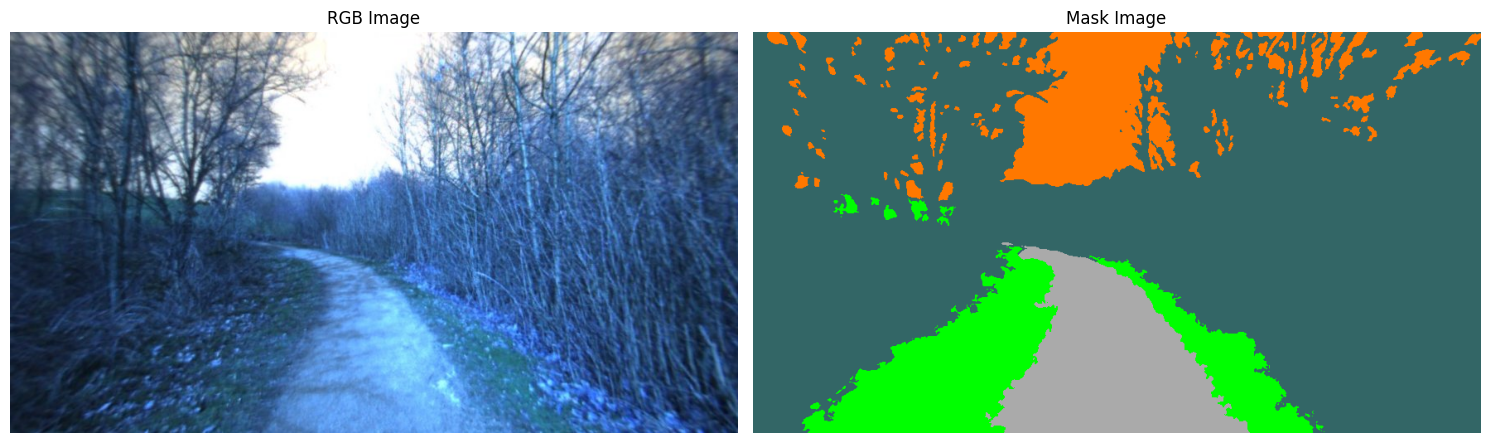

In [23]:
show_random_images(images_train, mask_train)

In [24]:
path = '/hdd/team_2/freiburg_forest/'
images_test_path = os.path.join(path,'freiburg_forest_annotated', 'test','rgb')
images_test = sorted(glob.glob(os.path.join(images_test_path, "**/*.jpg"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_test_path, len(images_test)))

depth_test_path = os.path.join(path,'freiburg_forest_annotated', 'test','depth_gray')
depth_test = sorted(glob.glob(os.path.join(depth_test_path, "**/*.png"), recursive=True))
print("DEPTH {} ### Total:  {}".format(depth_test_path, len(depth_test)))

mask_test_path = os.path.join(path,'freiburg_forest_annotated', 'test','GT_color')
mask_test = sorted(glob.glob(os.path.join(mask_test_path, "**/*.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_test_path, len(mask_test)))

IMAGES /hdd/team_2/freiburg_forest/freiburg_forest_annotated/test/rgb ### Total:  136
DEPTH /hdd/team_2/freiburg_forest/freiburg_forest_annotated/test/depth_gray ### Total:  136
MASK /hdd/team_2/freiburg_forest/freiburg_forest_annotated/test/GT_color ### Total:  136


image (488, 879, 3)
mask (488, 879, 3)


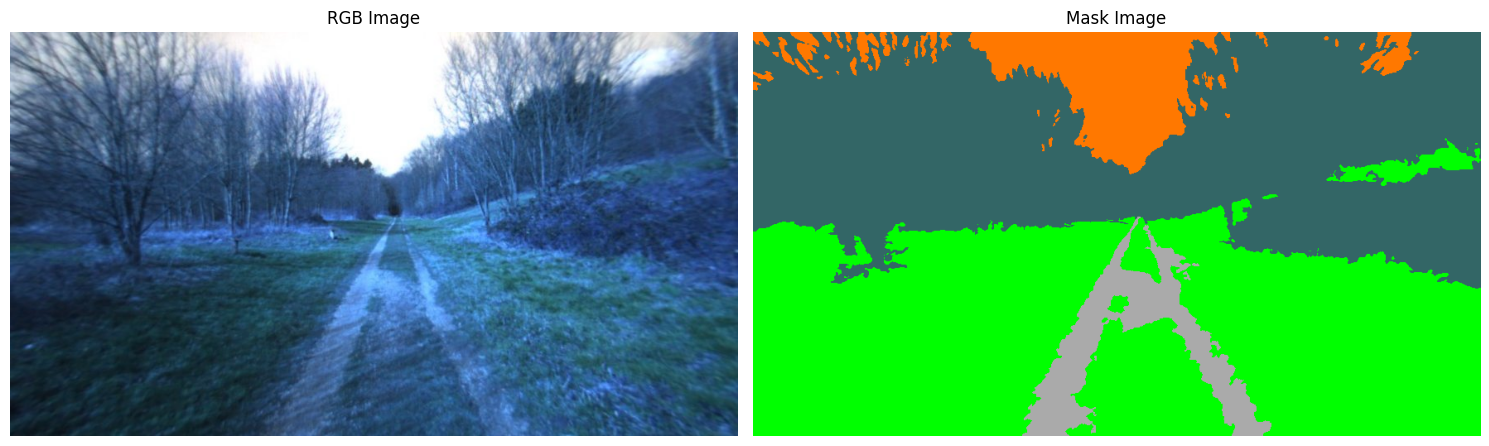

In [25]:
show_random_images(images_test, mask_test)

In [26]:
df_train_fr = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_fr['rgb_path'] = images_train
df_train_fr['depth_path'] = depth_train
df_train_fr['mask_path'] = mask_train
df_train_fr['dataset']  = 'FREIBURG' 
df_train_fr['class'] = 0 # off-road
df_train_fr

,rgb_path,depth_path,mask_path,dataset,class
0,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
1,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
2,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
3,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
4,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
...,...,...,...,...,...
225,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
226,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
227,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
228,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0


In [27]:
df_test_fr = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_test_fr['rgb_path'] = images_test
df_test_fr['depth_path'] = depth_test
df_test_fr['mask_path'] = mask_test
df_test_fr['dataset']  = 'FREIBURG'
df_test_fr['class'] = 0 # off-road
df_test_fr

,rgb_path,depth_path,mask_path,dataset,class
0,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
1,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
2,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
3,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
4,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
...,...,...,...,...,...
131,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
132,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
133,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0
134,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,/hdd/team_2/freiburg_forest/freiburg_forest_an...,FREIBURG,0


In [28]:
from sklearn.model_selection import train_test_split
df_test_fr, df_valid_fr = train_test_split(df_test_fr, test_size=0.20, random_state=42)
print("train data: {}".format(len(df_train_fr)))
print("test data: {}".format(len(df_test_fr)))
print("valid data: {}".format(len(df_valid_fr)))

train data: 230
test data: 108
valid data: 28


In [29]:
# df_train.to_csv("data_splits/train_path.csv")
# df_valid.to_csv("data_splits/valid_path.csv")
# df_test.to_csv("data_splits/test_path.csv")

# ORFD

https://drive.google.com/drive/folders/1uXHRnioK1CqwOaDIpKdEuvJhqtJZ1LEc

Dataset location:

```
hdd/team_2/ORFD/Final_Dataset
```

In [30]:
path = '/hdd/team_2/ORFD/Final_Dataset'
images_train_path = os.path.join(path, 'training','image_data')
images_orfd_train = sorted(glob.glob(os.path.join(images_train_path, "*.png"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_orfd_train)))

depth_train_path = os.path.join(path,'training','dense_depth')
depth_orfd_train = sorted(glob.glob(os.path.join(depth_train_path, "*.png"), recursive=False))
print("DEPTH {} ### Total:  {}".format(depth_train_path, len(depth_orfd_train)))

mask_train_path = os.path.join(path,'training','gt_image')
mask_orfd_train = sorted(glob.glob(os.path.join(mask_train_path, "*.png"), recursive=False))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_orfd_train)))

IMAGES /hdd/team_2/ORFD/Final_Dataset/training/image_data ### Total:  8392
DEPTH /hdd/team_2/ORFD/Final_Dataset/training/dense_depth ### Total:  8392
MASK /hdd/team_2/ORFD/Final_Dataset/training/gt_image ### Total:  8392


image (720, 1280, 3)
mask (720, 1280, 3)


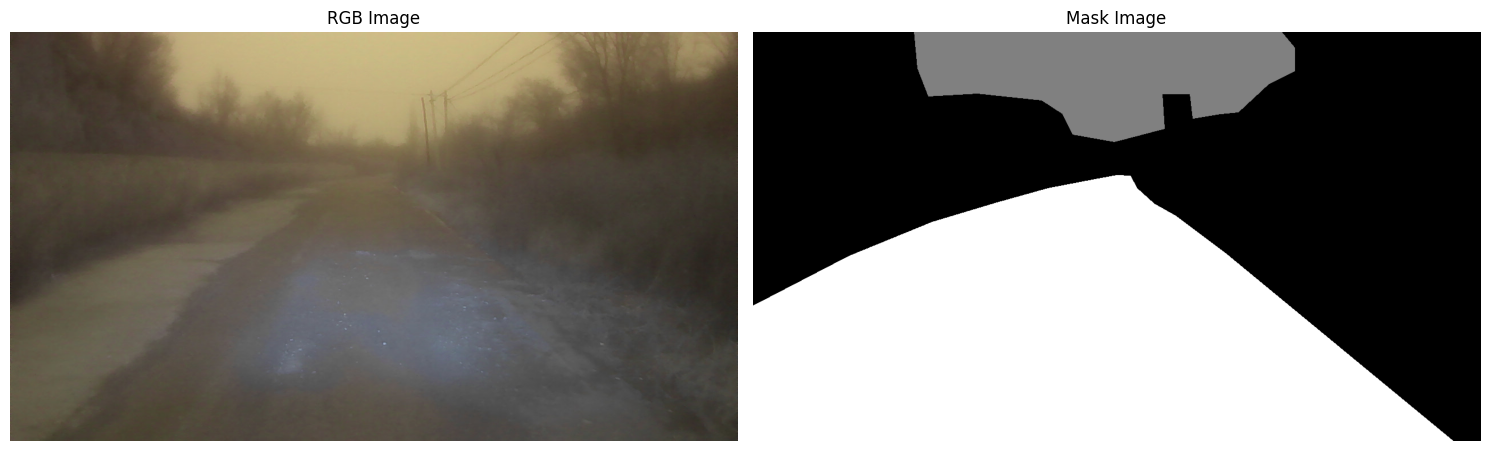

In [31]:
show_random_images(images_orfd_train, mask_orfd_train)

In [32]:
images_test_path = os.path.join(path, 'testing','image_data')
images_orfd_test = sorted(glob.glob(os.path.join(images_test_path, "*.png"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_test_path, len(images_orfd_test)))

depth_test_path = os.path.join(path,'testing','dense_depth')
depth_orfd_test = sorted(glob.glob(os.path.join(depth_test_path, "*.png"), recursive=False))
print("DEPTH {} ### Total:  {}".format(depth_test_path, len(depth_orfd_test)))

mask_test_path = os.path.join(path,'testing','gt_image')
mask_orfd_test = sorted(glob.glob(os.path.join(mask_test_path, "*.png"), recursive=False))
print("MASK {} ### Total:  {}".format(mask_test_path, len(mask_orfd_test)))

IMAGES /hdd/team_2/ORFD/Final_Dataset/testing/image_data ### Total:  2193
DEPTH /hdd/team_2/ORFD/Final_Dataset/testing/dense_depth ### Total:  2193
MASK /hdd/team_2/ORFD/Final_Dataset/testing/gt_image ### Total:  2193


In [33]:
images_valid_path = os.path.join(path, 'validation','image_data')
images_orfd_valid = sorted(glob.glob(os.path.join(images_valid_path, "*.png"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_valid_path, len(images_orfd_valid)))

depth_valid_path = os.path.join(path,'validation','dense_depth')
depth_orfd_valid = sorted(glob.glob(os.path.join(depth_valid_path, "*.png"), recursive=False))
print("DEPTH {} ### Total:  {}".format(depth_valid_path, len(depth_orfd_valid)))

mask_valid_path = os.path.join(path,'validation','gt_image')
mask_orfd_valid = sorted(glob.glob(os.path.join(mask_valid_path, "*.png"), recursive=False))
print("MASK {} ### Total:  {}".format(mask_valid_path, len(mask_orfd_valid)))

IMAGES /hdd/team_2/ORFD/Final_Dataset/validation/image_data ### Total:  1245
DEPTH /hdd/team_2/ORFD/Final_Dataset/validation/dense_depth ### Total:  1245
MASK /hdd/team_2/ORFD/Final_Dataset/validation/gt_image ### Total:  1245


In [34]:
df_train_orfd = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_orfd['rgb_path'] = images_orfd_train
df_train_orfd['depth_path'] = depth_orfd_train
df_train_orfd['mask_path'] = mask_orfd_train
df_train_orfd['dataset']  = 'ORFD'

In [35]:
df_test_orfd = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_test_orfd['rgb_path'] = images_orfd_test
df_test_orfd['depth_path'] = depth_orfd_test
df_test_orfd['mask_path'] = mask_orfd_test
df_test_orfd['dataset']  = 'ORFD'
df_test_orfd['class'] = 0

In [36]:
df_valid_orfd = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_valid_orfd['rgb_path'] = images_orfd_valid
df_valid_orfd['depth_path'] = depth_orfd_valid
df_valid_orfd['mask_path'] = mask_orfd_valid
df_valid_orfd['dataset']  = 'ORFD'
df_valid_orfd['class'] = 0

In [37]:
print("train data: {}".format(len(df_train_orfd)))
print("test data: {}".format(len(df_test_orfd)))
print("validation data: {}".format(len(df_valid_orfd)))

train data: 8392
test data: 2193
validation data: 1245


# Cityscapes


https://www.cityscapes-dataset.com/examples/#fine-annotations

Dataset location:

```
/hdd/team_2/freiburg_forest
```

In [38]:
from collections import namedtuple
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [39]:
# Train Data COARSE
path = '/hdd/team_2/Cityscapes/'
images_train_path = os.path.join(path,'leftImg8bit','train_extra')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

mask_train_path = os.path.join(path,'gtCoarse', 'gtCoarse','train_extra')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

# Valid Data
images_valid_path = os.path.join(path,'leftImg8bit_trainvaltest','leftImg8bit', 'val')
images_valid = sorted(glob.glob(os.path.join(images_valid_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_valid_path, len(images_valid)))

mask_valid_path = os.path.join(path,'gtCoarse', 'gtCoarse','val',)
mask_valid = sorted(glob.glob(os.path.join(mask_valid_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_valid_path, len(mask_valid)))


df_train_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_city['rgb_path'] = images_train
df_train_city['mask_path'] = mask_train
df_train_city['dataset']  = 'CITYSCAPES'
df_train_city['class'] = 1 # On-road Data

df_train_city, df_test_city = train_test_split(df_train_city, test_size=0.20, random_state=42)

df_valid_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_valid_city['rgb_path'] = images_valid
df_valid_city['mask_path'] = mask_valid
df_valid_city['dataset']  = 'CITYSCAPES'
df_valid_city['class'] = 1 # On-road Data
print("train data: {}".format(len(df_train_city)))
print("test data: {}".format(len(df_test_city)))
print("val data: {}".format(len(df_valid_city)))



IMAGES /hdd/team_2/Cityscapes/leftImg8bit/train_extra ### Total:  19998
MASK /hdd/team_2/Cityscapes/gtCoarse/gtCoarse/train_extra ### Total:  19998
IMAGES /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val ### Total:  500
MASK /hdd/team_2/Cityscapes/gtCoarse/gtCoarse/val ### Total:  500
train data: 15998
test data: 4000
val data: 500


## concat all dataset

In [40]:
df_train = pd.concat([df_train_fr, df_train_orfd, df_train_city])
train_shuffle = shuffle(df_train, random_state=42)

df_test = pd.concat([df_test_fr,df_test_city,  df_test_orfd])
test_shuffle = shuffle(df_test, random_state=42)

df_valid = pd.concat([df_valid_fr, df_valid_orfd,df_valid_city])
valid_shuffle = shuffle(df_valid, random_state=42)

print("Train data: {}".format(len(train_shuffle)))
print("Test data: {}".format(len(test_shuffle)))
print("Validation data: {}".format(len(valid_shuffle)))

# train_shuffle.to_csv("data_splits/train_path.csv")
# valid_shuffle.to_csv("data_splits/valid_path.csv")
# test_shuffle.to_csv("data_splits/test_path.csv")

Train data: 24620
Test data: 6301
Validation data: 1773


## Dataset basic analytics

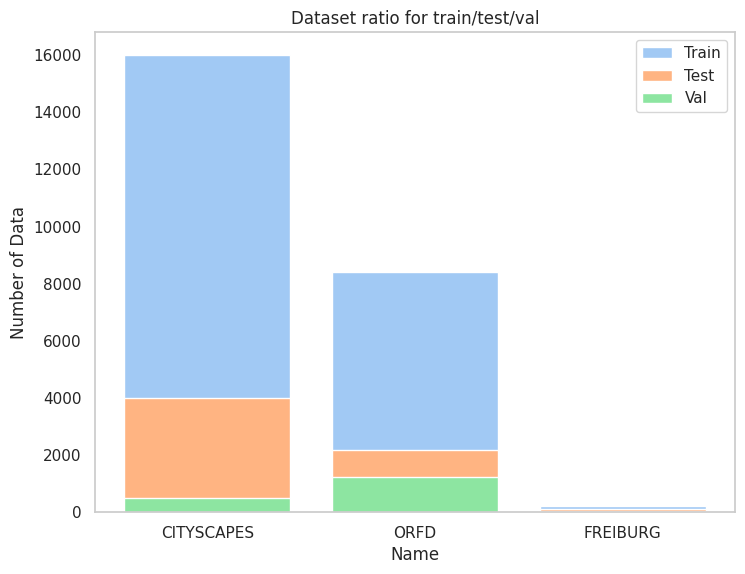

In [41]:
import seaborn as sns 

train_counts = df_train['dataset'].value_counts()
test_counts = df_test['dataset'].value_counts()
val_counts = df_valid['dataset'].value_counts()

sns.set_theme(style="whitegrid", palette="pastel")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(train_counts.index, train_counts.values,label='Train')
ax.bar(test_counts.index, test_counts.values,label='Test')
ax.bar(val_counts.index, val_counts.values,label='Val')
plt.xlabel('Name')
plt.ylabel('Number of Data')
plt.title('Dataset ratio for train/test/val')
plt.legend()
plt.grid(False)
plt.show()

## ON FINE DATA

In [42]:
path = '/hdd/team_2/Cityscapes/'
images_train_path = os.path.join(path,'leftImg8bit_trainvaltest','leftImg8bit','train')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))
mask_train_path = os.path.join(path,'gtFine','train')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

IMAGES /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train ### Total:  2975
MASK /hdd/team_2/Cityscapes/gtFine/train ### Total:  2975


In [43]:
# INVALID DATA !! 

# path = '/hdd/team_2/Cityscapes/'
# images_test_path = os.path.join(path,'leftImg8bit_trainvaltest', 'leftImg8bit','test')
# images_test = sorted(glob.glob(os.path.join(images_test_path, "**/*.png"), recursive=True))
# print("IMAGES {} ### Total:  {}".format(images_test_path, len(images_test)))

# mask_test_path = os.path.join(path,'gtFine','test')
# mask_test = sorted(glob.glob(os.path.join(mask_test_path, "**/*color.png"), recursive=True))
# print("MASK {} ### Total:  {}".format(mask_test_path, len(mask_test)))




In [44]:
# Valid Data
path = '/hdd/team_2/Cityscapes/'
images_val_path = os.path.join(path,'leftImg8bit_trainvaltest', 'leftImg8bit','val')
images_val = sorted(glob.glob(os.path.join(images_val_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_val_path, len(images_val)))

mask_val_path = os.path.join(path,'gtFine','val')
mask_val = sorted(glob.glob(os.path.join(mask_val_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_val_path, len(mask_val)))

IMAGES /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val ### Total:  500
MASK /hdd/team_2/Cityscapes/gtFine/val ### Total:  500


In [45]:
df_train_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_city['rgb_path'] = images_train
df_train_city['mask_path'] = mask_train
df_train_city['dataset']  = 'CITYSCAPES'
df_train_city['class'] = 1 # On-road Data


df_valid_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_valid_city['rgb_path'] = images_val
df_valid_city['mask_path'] = mask_val
df_valid_city['dataset']  = 'CITYSCAPES'
df_valid_city['class'] = 1 # On-road Data

df_train_city, df_test_city = train_test_split(df_train_city, test_size=0.20, random_state=42)



print("train data: {}".format(len(df_train_city)))
print("test data: {}".format(len(df_test_city)))
print("val data: {}".format(len(df_valid_city)))

train data: 2380
test data: 595
val data: 500


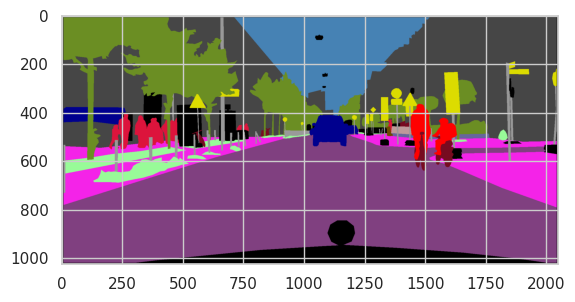

In [46]:
data = cv2.imread(df_train_city["mask_path"].iloc[10])
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
plt.imshow(data)

In [48]:
train_shuffle = shuffle(df_train_city, random_state=42)

test_shuffle = shuffle(df_test_city, random_state=42)

valid_shuffle = shuffle(df_valid_city, random_state=42)

print("Train data: {}".format(len(train_shuffle)))
print("Test data: {}".format(len(test_shuffle)))
print("Validation data: {}".format(len(valid_shuffle)))

# train_shuffle.to_csv("data_splits/train_path.csv")
# valid_shuffle.to_csv("data_splits/valid_path.csv")
# test_shuffle.to_csv("data_splits/test_path.csv")

Train data: 2380
Test data: 595
Validation data: 500


In [49]:
def show_random_images_cityscapes(images, masks, labels, id):
    # Randomly choose an image from each list
    random_choice = int(random.choice(np.arange(0,len(images),1)))
    
    # Load the images using PIL
    img = cv2.imread(images[random_choice])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks[random_choice])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    print("image {}".format(images[random_choice]))
    print("mask {}".format(masks[random_choice]))

    # mask = cv2.resize(mask, [256, 256])
    road_label = np.array(labels[id].color)
    mask = np.all(mask == road_label, axis=-1).astype(np.uint8)

    print("image {}".format(img.shape))
    print("mask {}".format(mask.shape))
    
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(img)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(mask)
    axes[1].set_title('Mask Image')
    axes[1].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

image /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/monchengladbach/monchengladbach_000000_033683_leftImg8bit.png
mask /hdd/team_2/Cityscapes/gtFine/train/monchengladbach/monchengladbach_000000_033683_gtFine_color.png
image (1024, 2048, 3)
mask (1024, 2048)


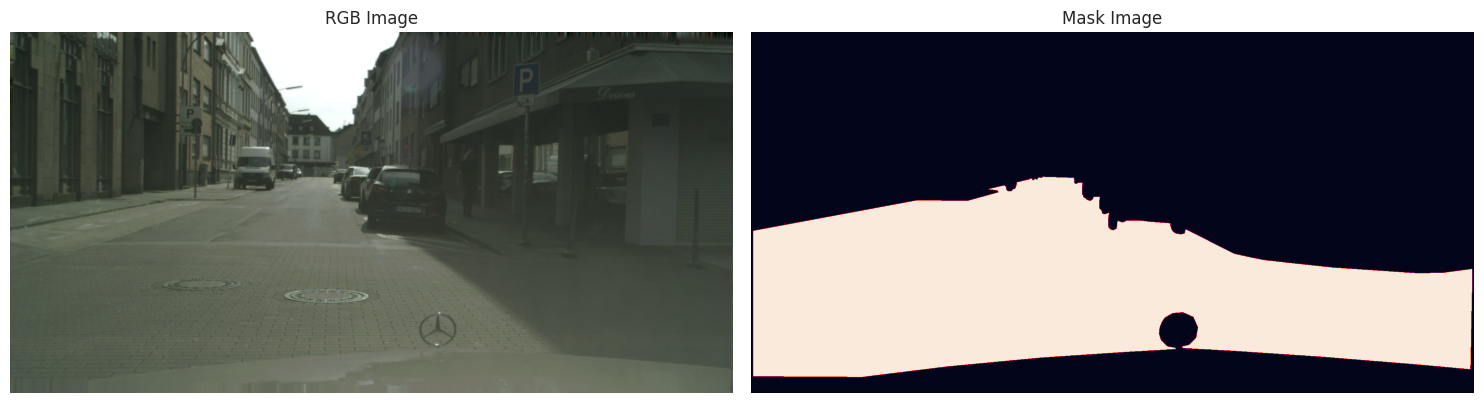

In [50]:
show_random_images_cityscapes(df_train_city["rgb_path"].values, df_train_city["mask_path"].values, labels, 7)

image /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/strasbourg/strasbourg_000001_058105_leftImg8bit.png
mask /hdd/team_2/Cityscapes/gtFine/train/strasbourg/strasbourg_000001_058105_gtFine_color.png
image (1024, 2048, 3)
mask (1024, 2048)


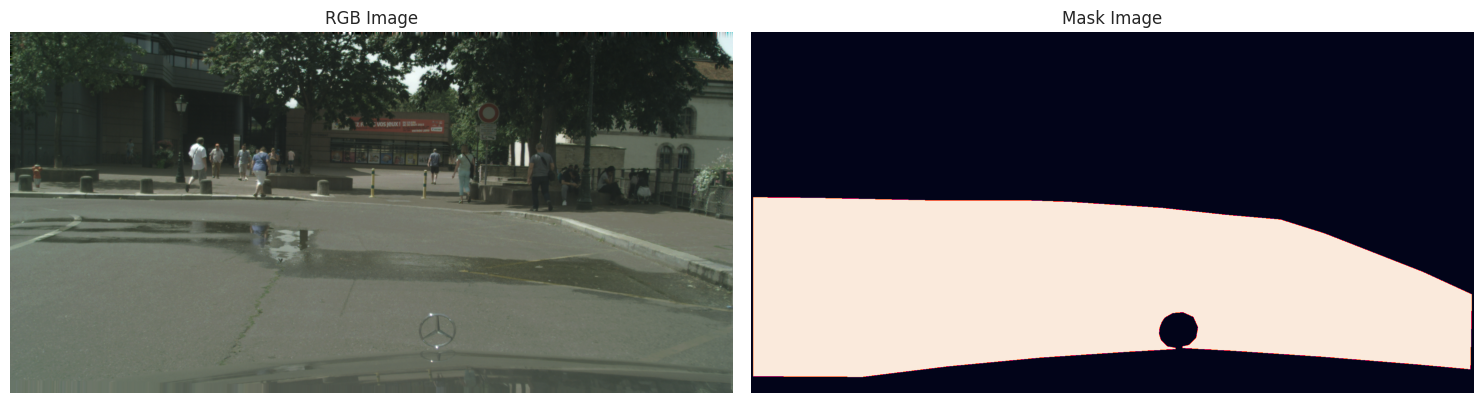

In [33]:
show_random_images_cityscapes(df_test_city["rgb_path"].values, df_test_city["mask_path"].values, labels, 7)

In [52]:
image = cv2.imread(df_test_city["rgb_path"][0])

In [57]:
image.shape[0]//2

512